In [2]:
import re
import csv
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_trf')
import networkx as nx

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import urllib.request 

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [3]:
# importing required modules
from pypdf import PdfReader
import os
# assign directory
directory = '../docs2'

parsed_text = ""
    
# iterate over files in
# that directory
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        # creating a pdf file object
        pdfFileObj = open(f, 'rb')

        # creating a pdf reader object
        pdfReader = PdfReader(pdfFileObj)

        # printing number of pages in pdf file
        print(len(pdfReader.pages))

        # creating a page object
        for page in pdfReader.pages:
            # extracting text from page
            parsed_text = " ".join((parsed_text, str(page.extract_text())))

            # closing the pdf file object
        pdfFileObj.close()


sentences = [[i] for i in nlp(parsed_text).sents]

12


In [4]:
headers = ['sentence']
values = sentences
filename = 'doc_text.csv'
with open(filename, 'w',newline='',encoding="utf-8") as data:
    writer = csv.writer(data)
    writer.writerow(headers)
    writer.writerows(values)

In [5]:
csv_sentences = pd.read_csv("doc_text_clean.csv")

In [6]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [7]:
entity_pairs = []

for i in tqdm(csv_sentences["sentence"]):
    entity_pairs.append(get_entities(i))

100%|██████████| 347/347 [00:23<00:00, 14.54it/s]


In [18]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1",[pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [19]:
relations = [get_relation(i) for i in tqdm(csv_sentences["sentence"])]






  0%|          | 0/347 [00:00<?, ?it/s]




  1%|          | 2/347 [00:00<00:20, 16.69it/s]




  1%|          | 4/347 [00:00<00:26, 12.85it/s]




  2%|▏         | 6/347 [00:00<00:24, 14.17it/s]




  2%|▏         | 8/347 [00:00<00:23, 14.42it/s]




  3%|▎         | 10/347 [00:00<00:23, 14.36it/s]




  3%|▎         | 12/347 [00:00<00:24, 13.81it/s]




  4%|▍         | 14/347 [00:00<00:23, 14.17it/s]




  5%|▍         | 16/347 [00:01<00:24, 13.74it/s]




  5%|▌         | 18/347 [00:01<00:23, 13.78it/s]




  6%|▌         | 20/347 [00:01<00:23, 14.21it/s]

IndexError: list index out of range





  6%|▌         | 20/347 [00:14<00:23, 14.19it/s]




  6%|▌         | 20/347 [00:13<00:23, 14.21it/s]

In [9]:
pd.Series(relations).value_counts()[:50]

Conservation                 10
is                           10
are                           6
were                          6
governed by                   6
C15ª2023                      6
had                           6
crabs on                      4
used                          4
Downloaded from               4
depends on                    3
estimated                     3
C15(2023                      3
suggests                      3
conducted                     3
Settlement                    3
present                       3
was                           3
developed                     3
suggest                       2
Fishers                       2
expected                      2
challenging                   2
0.12                          2
survives on                   2
Caro                          2
tested                        2
have                          2
Islands                       2
modelled                      2
opted for                     2
leased f

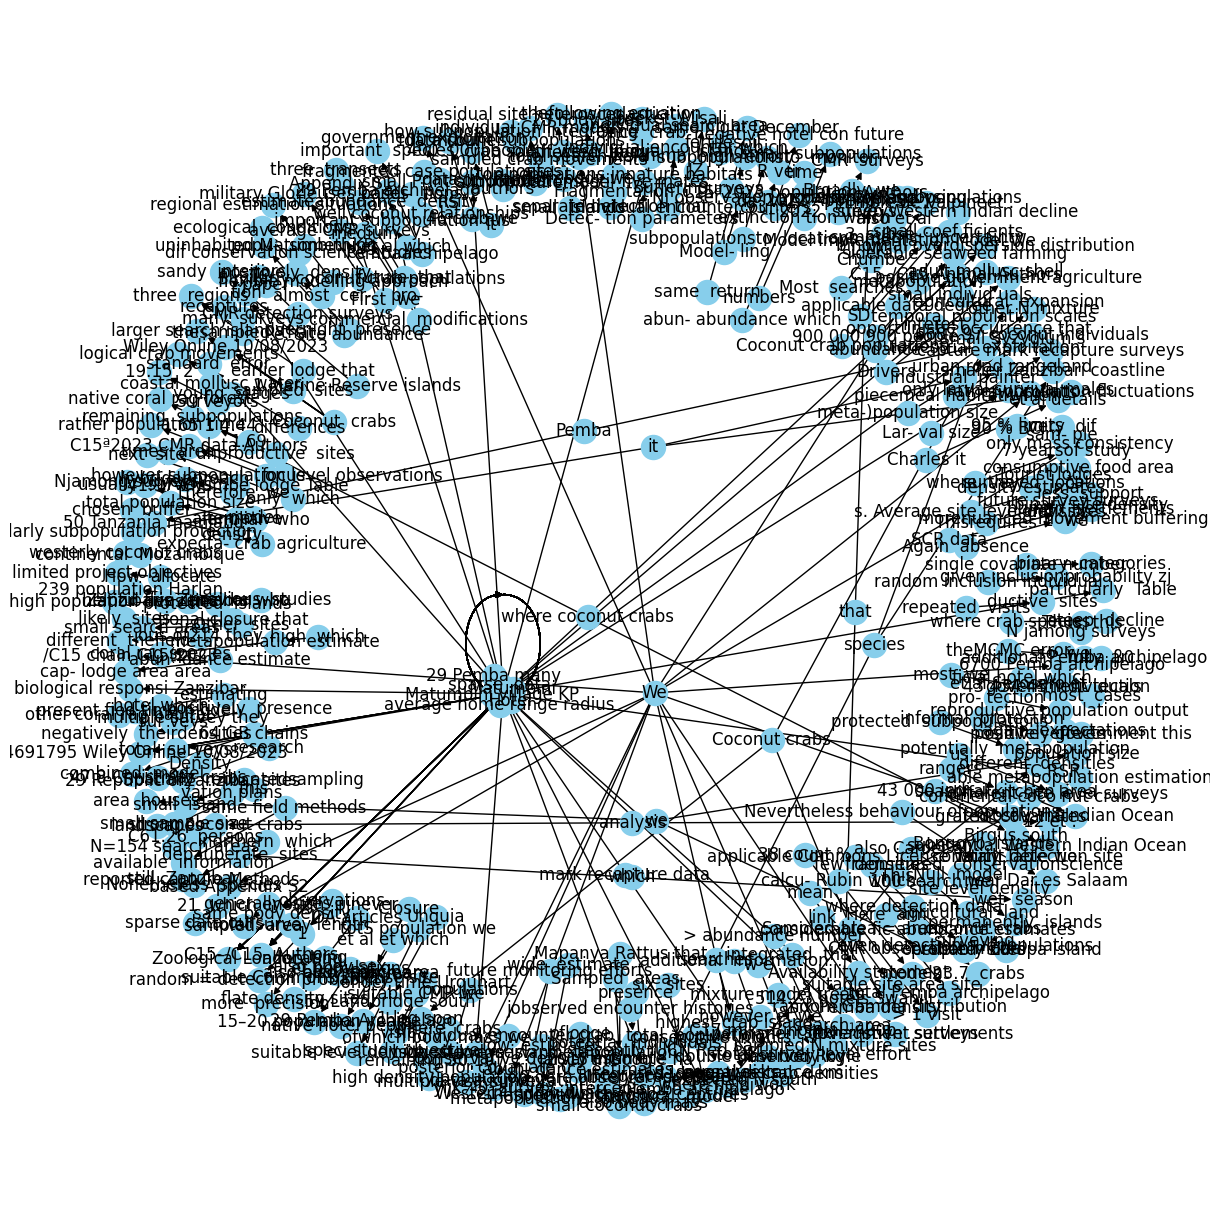

In [10]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())
                          

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

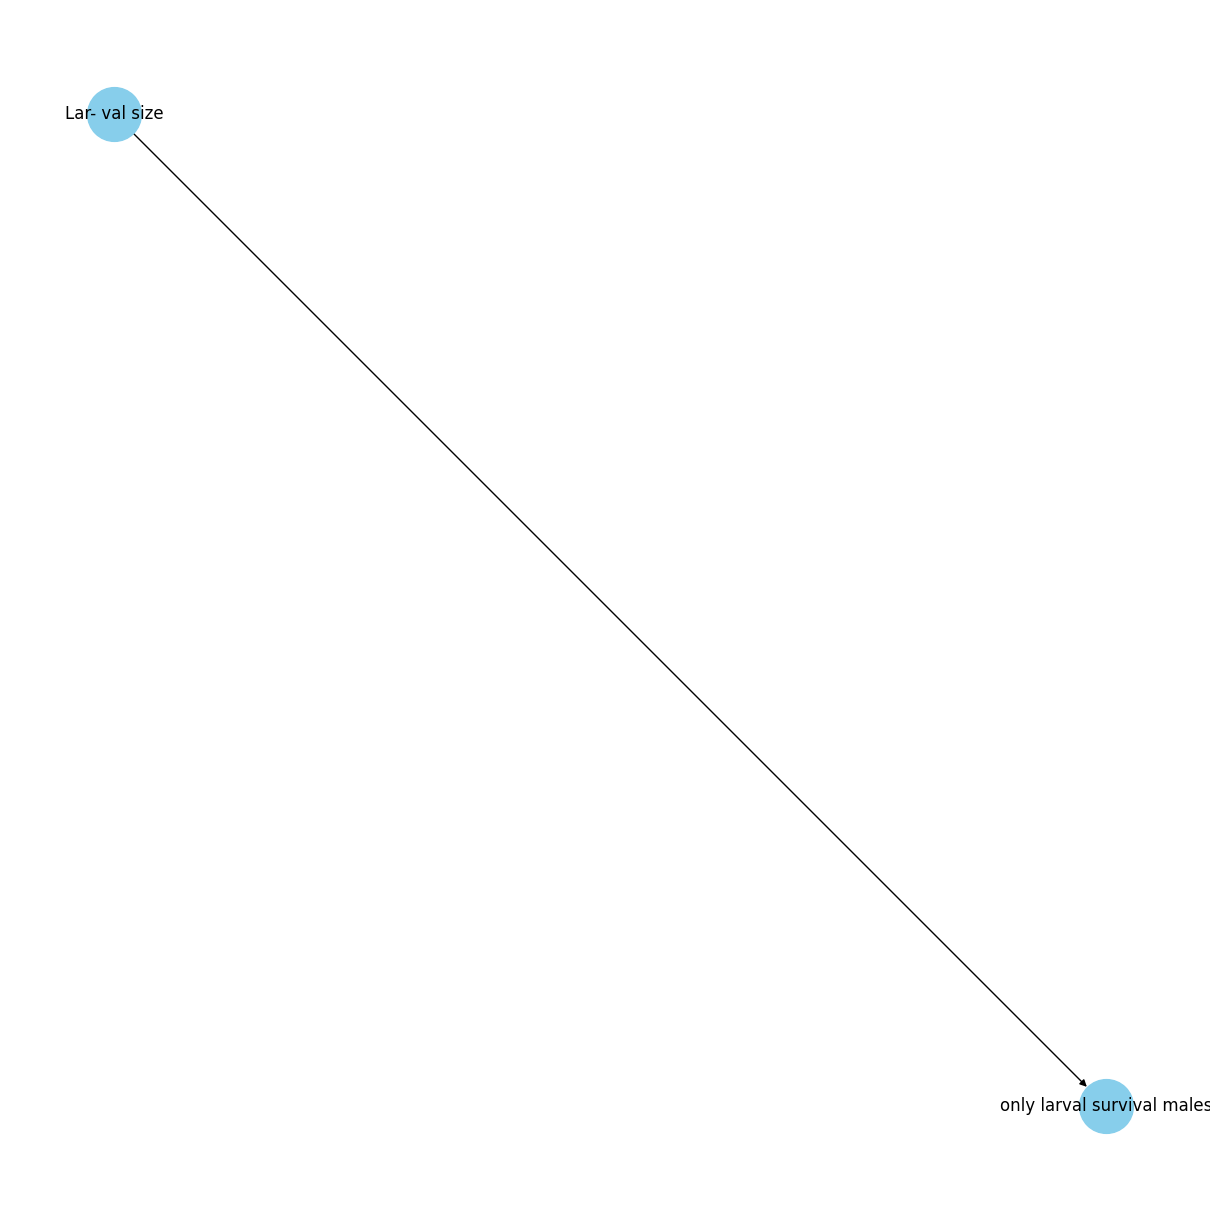

In [11]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="mate with"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()